<a href="https://colab.research.google.com/github/ElFosco/NLP_argument_creation/blob/main/seq2seq_arg_quality_one_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installations

In [1]:
!pip install -q tf-models-official
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 2.2 MB 5.4 MB/s 
     |████████████████████████████████| 99 kB 8.1 MB/s 
     |████████████████████████████████| 1.2 MB 44.0 MB/s 
     |████████████████████████████████| 237 kB 45.9 MB/s 
     |████████████████████████████████| 90 kB 8.7 MB/s 
     |████████████████████████████████| 352 kB 48.9 MB/s 
     |████████████████████████████████| 636 kB 49.3 MB/s 
     |████████████████████████████████| 47.8 MB 52 kB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 4.9 MB 32.0 MB/s 
     |████████████████████████████████| 1.1 MB 37.1 MB/s 
     |████████████████████████████████| 462 kB 34.5 MB/s 
     |████████████████████████████████| 123 kB 5.4 MB/s 
     |████████████████████████████████| 132 kB 31.4 MB/s 
     |████████████████████████████████| 79 kB 7.0 MB/s 
     |████████████████████████████████| 8.7 MB 34.8 MB/s 
     |████████████████████████████████| 138 kB 38.4 MB/s 
     |███████████████████

## Imports

In [2]:
import os
import re
import numpy as np
import math
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# Perplexity
import torch
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTModel, OpenAIGPTLMHeadModel

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# BERT
import tensorflow_hub as hub
import tensorflow_text as text

# Embeddings
import gensim  
import gensim.downloader as gloader

# Data & Pre-processing
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import pandas as pd


# Defining hyperparameters
BUFFER_SIZE = 10000
TRAIN_BUFFER = 256  # Shoud be lower than BUFFER_SIZE
EMBED_DIM = 100
LATENT_DIM = 512
NUM_HEADS = 8
BATCH_SIZE = 256
BATCH_SIZE_RL = 32

# Datasets
train_dataset = "/gdrive/MyDrive/NLP/arg_quality_rank_30k.csv"

# Embedding model
embed_model = "/gdrive/MyDrive/NLP/glove_{}_pickle".format(EMBED_DIM)

# BERT models weights
quality_model_weights = "/gdrive/MyDrive/NLP/classifierIBM30k.h5"
r1_model_weights = "/gdrive/MyDrive/NLP/classifierNLI.h5"

# BERT model scores of start sentences, based on best model of BERT
start_scores = "/gdrive/MyDrive/NLP/start_scores_bert_pickle"

# Whether or not to add noise in the one-hot encoding of the batch (RL)
add_noise_one_hot = False

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Data

### Methods

In [4]:
lemmatizer = WordNetLemmatizer()
def preprocess_pretrain(text):
    text = text.lower()
    text = re.sub('\"|-|\\\\|`', ' ', text)  # delete this chars from the string ["-\`]
    text = re.sub('\n', ' ', text)
    text = re.sub('^[.]+', '', text)         # delete dots at the beginning of the sentence
    text = re.sub("([?.!,])", r" \1 ", text)
    text = re.sub('\. \.', '.', text)        # delete . .
    text = re.sub('&', ' and ', text)        # replace & with and
    text = re.sub(' +', ' ', text)           # delete additional whitespace
    text = text.strip()
    text = " ".join(["[start]", text, "[end]"])
    text = " ".join([lemmatizer.lemmatize(x) for x in text.split()])
    return text


def preprocess_rl(text):
    text = text.lower()
    text = re.sub('\"|-|\\\\|`', ' ', text)  # delete this chars from the string ["-\`]
    text = re.sub('\n', ' ', text)
    text = re.sub('^[.]+', '', text)         # delete dots at the beginning of the sentence
    text = re.sub("([?.!,])", r" \1 ", text)
    text = re.sub('\. \.', '.', text)        # delete . .
    text = re.sub('&', ' and ', text)        # replace & with and
    text = re.sub(' +', ' ', text)           # delete additional whitespace
    text = text.strip()
    text = " ".join([lemmatizer.lemmatize(x) for x in text.split()])
    return text


def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """

    download_path = ""

    # Find the correct embedding model name
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")

    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model


def check_OOV_terms(embedding_vocabulary, word_listing):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_vocabulary: pre-trained word embedding model vocab (list)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)


def build_embedding_matrix(embedding_model,
                           embedding_dimension,
                           word_to_idx,
                           vocab_size,
                           oov_terms):
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix


def update_embedding_matrix(embedding_model, 
                            embedding_dimension,
                            word_to_idx,
                            vocab_size,
                            oov_terms):
    """
    Builds the embedding matrix of a specific dataset given a pre-trained emdedding matrix

    :param embedding_model: pre-trained embedding matrix
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[idx]
        except (TypeError, IndexError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix


class KerasTokenizer(object):
    """
    A simple high-level wrapper for the Keras tokenizer.
    """

    def __init__(self, build_embedding_matrix=False, embedding_dimension=None,
                 embedding_model_type=None, tokenizer_args=None, embedding_model=None):
        if build_embedding_matrix:
            assert embedding_model_type is not None
            assert embedding_dimension is not None and type(embedding_dimension) == int

        self.build_embedding_matrix = build_embedding_matrix
        self.embedding_dimension = embedding_dimension
        self.embedding_model_type = embedding_model_type
        self.embedding_model = embedding_model
        self.embedding_matrix = None
        self.vocab = None

        tokenizer_args = {} if tokenizer_args is None else tokenizer_args
        assert isinstance(tokenizer_args, dict) or isinstance(tokenizer_args, collections.OrderedDict)

        self.tokenizer_args = tokenizer_args

    def build_vocab(self, data, **kwargs):
        print('Fitting tokenizer...')
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(**self.tokenizer_args)
        self.tokenizer.fit_on_texts(data)
        print('Fit completed!')

        self.vocab = self.tokenizer.word_index

        if self.build_embedding_matrix:
            if self.embedding_model is None:
              print('Loading embedding model! It may take a while...')
              self.embedding_model = load_embedding_model(model_type=self.embedding_model_type, 
                                                          embedding_dimension=self.embedding_dimension)
            
            print('Checking OOV terms in train...')
            self.oov_terms_train = check_OOV_terms(embedding_vocabulary=set(self.embedding_model.vocab.keys()),
                                             word_listing=list(self.vocab.keys()))
            
            print("Total OOV terms: {0} ({1:.2f}%)".format(len(self.oov_terms_train), 100*float(len(self.oov_terms_train)) / len(self.vocab)))

            print('Building the embedding matrix for train...')
            self.embedding_matrix = build_embedding_matrix(embedding_model=self.embedding_model,
                                                           word_to_idx=self.vocab,
                                                           vocab_size=len(self.vocab)+1,          
                                                           embedding_dimension=self.embedding_dimension,
                                                           oov_terms=self.oov_terms_train)
            print('Done for train!')

    def update_vocab(self, data, **kwargs):
      self.tokenizer.fit_on_texts(data)
      if self.build_embedding_matrix:
        old_vocab = self.vocab
        self.vocab = self.tokenizer.word_index
        print('Checking OOV terms...')
        self.oov_terms = check_OOV_terms(embedding_vocabulary=set(old_vocab.keys()), 
                                         word_listing=list(self.vocab.keys()))
        
        print("Total OOV terms: {0} ({1:.2f}%)".format(len(self.oov_terms), 100*float(len(self.oov_terms)) / len(self.vocab)))

        print('Building the embedding matrix...')
        self.embedding_matrix = update_embedding_matrix(embedding_model=self.embedding_matrix,
                                                       word_to_idx=self.vocab,
                                                       vocab_size=len(self.vocab)+1,          
                                                       embedding_dimension=self.embedding_dimension,
                                                       oov_terms=self.oov_terms)

    def get_info(self):
        return {
            'build_embedding_matrix': self.build_embedding_matrix,
            'embedding_dimension': self.embedding_dimension,
            'embedding_model_type': self.embedding_model_type,
            'embedding_matrix': self.embedding_matrix.shape if self.embedding_matrix is not None else self.embedding_matrix,
            'embedding_model': self.embedding_model,
            'vocab_size': len(self.vocab) + 1,
        }

    def tokenize(self, text):
        return text

    def convert_tokens_to_ids(self, tokens):
        if type(tokens) == str:
            return self.tokenizer.texts_to_sequences([tokens])[0]
        else:
            return self.tokenizer.texts_to_sequences(tokens)

    def convert_ids_to_tokens(self, ids):
        return self.tokenizer.sequences_to_texts(ids)


def convert_text(df, tokenizer, is_training=False, max_seq_length=None):
    """
    Converts input text sequences using a given tokenizer

    :param texts: either a list or numpy ndarray of strings
    :tokenizer: an instantiated tokenizer
    :is_training: whether input texts are from the training split or not
    :max_seq_length: the max token sequence previously computed with
    training texts.

    :return
        text_ids: a nested list on token indices
        max_seq_length: the max token sequence previously computed with
        training texts.
    """

    text_ids = tokenizer.convert_tokens_to_ids(df)

    # Padding
    if is_training:
        max_seq_length = int(np.quantile([len(seq) for seq in text_ids], 0.95))
    else:
        assert max_seq_length is not None

    text_ids = [seq + [0] * (max_seq_length - len(seq)) for seq in text_ids]
    text_ids = np.array([seq[:max_seq_length] for seq in text_ids])

    if is_training:
        return text_ids, max_seq_length
    else:
        return text_ids


def decode_sentence(input_sentence, preprocess, model):
    # Mapping the input sentence to tokens and adding start and end tokens
    tokenized_input_sentence = tokenizer.convert_tokens_to_ids(
        [preprocess(input_sentence)]
    )[0]
    tokenized_input_sentence = tf.pad(
        tokenized_input_sentence,
        [[0, max_seq_length - tf.shape(tokenized_input_sentence)[0]]])
    # Initializing the initial sentence consisting of only the start token.
    tokenized_target_sentence = tf.expand_dims(tokenizer.vocab["[start]"], 0)

    # Get the predictions
    predictions = model.predict(
        {
            "encoder_inputs": tf.expand_dims(tokenized_input_sentence, 0),
        }
    )
    # Calculating the token of step i (sentence len is i-1) with maximum probability and getting the corresponding word
    sampled_token_index = tf.argmax(predictions[0, :], axis=1)  # predictions.shape == (batch_size, max_seq_len, vocab_size)
    decoded_sentence = " ".join(tokenizer.convert_ids_to_tokens([sampled_token_index.numpy()]))
    return decoded_sentence

### Loading 

In [5]:
df = pd.read_csv(train_dataset)
df = df.drop(["WA", "stance_WA", "stance_WA_conf", "MACE-P"], axis=1)
df.head()

,argument,topic,set
0,"""marriage"" isn't keeping up with the times. a...",We should abandon marriage,train
1,.a multi-party system would be too confusing a...,We should adopt a multi-party system,train
2,\ero-tolerance policy in schools should not be...,We should adopt a zero-tolerance policy in sch...,dev
3,`people reach their limit when it comes to the...,Assisted suicide should be a criminal offence,train
4,"100% agree, should they do that, it would be a...",We should abolish safe spaces,train


### Data preprocessing

In [6]:
df.loc[2,"argument"] = "zero tolerance policy in schools should not be adopted as circumstances are often not black and white, being more nuanced. no one should be written off due to a mistake of judgement."
pretrain_series = df.apply(lambda row : preprocess_pretrain(row['argument']), axis = 1)

rl_series = df.apply(lambda row : preprocess_rl(row['argument']), axis = 1)
topic_list = list(df.apply(lambda row : row['topic'].lower(), axis = 1))
pretrain_series.head()

0    [start] marriage isn't keeping up with the tim...
1    [start] a multi party system would be too conf...
2    [start] zero tolerance policy in school should...
3    [start] people reach their limit when it come ...
4    [start] 100% agree , should they do that , it ...
dtype: object

### Train, test, val splits

In [7]:
is_training_data =  df['set']=='train'
is_validation_data =  df['set']=='dev'
is_test_data =  df['set']=='test'

x_train = pretrain_series[is_training_data]
x_train = x_train.append(pretrain_series[is_validation_data])
x_test  = pretrain_series[is_test_data]

### Tokenization

In [8]:
# load embeddings from glove
import pickle
if os.path.exists(embed_model):
  with open(embed_model, "rb") as f:
    embedding_model = pickle.load(f)
else:
  embedding_model = load_embedding_model(model_type="glove", 
                                         embedding_dimension=EMBED_DIM)

In [9]:
# creating tokenizer and vocabulary

tokenizer_args = {
    'oov_token': "OOV_TOKEN",  # The vocabulary id for unknown terms during text conversion
    'lower' : True,  # default
    'filters' : '' 
}

tokenizer = KerasTokenizer(tokenizer_args=tokenizer_args,
                           build_embedding_matrix=True,
                           embedding_dimension=EMBED_DIM,
                           embedding_model_type="glove", 
                           embedding_model=embedding_model)

tokenizer.build_vocab(x_train)
tokenizer.update_vocab(x_test)
VOCAB_SIZE = len(tokenizer.vocab)

tokenizer_info = tokenizer.get_info()

print('Tokenizer info: ', tokenizer_info)

Fitting tokenizer...
Fit completed!
Checking OOV terms in train...
Total OOV terms: 1372 (12.32%)
Building the embedding matrix for train...


100%|██████████| 11138/11138 [00:00<00:00, 217300.63it/s]

Done for train!


Checking OOV terms...
Total OOV terms: 1328 (10.65%)
Building the embedding matrix...


100%|██████████| 12466/12466 [00:00<00:00, 379358.28it/s]

Tokenizer info:  {'build_embedding_matrix': True, 'embedding_dimension': 100, 'embedding_model_type': 'glove', 'embedding_matrix': (12467, 100), 'embedding_model': <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x7fc324ab4d10>, 'vocab_size': 12467}


### Tokenizing and padding sentences using `TextVectorization`

In [10]:
x_train_tokens, max_seq_length = convert_text(x_train, tokenizer, True)
x_test_tokens = convert_text(x_test, tokenizer, max_seq_length=max_seq_length)
print("Max token sequence: {}".format(max_seq_length))
print('X train shape: ', x_train_tokens.shape)
print('X test shape: ', x_test_tokens.shape)

Max token sequence: 37
X train shape:  (24182, 37)
X test shape:  (6315, 37)


### Tensorflow Dataset for Pre-training

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_tokens, x_train_tokens))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_tokens, x_test_tokens))

def vectorize_text(inputs, outputs):
    # One extra padding token to the right to match the output shape
    outputs = tf.pad(outputs, [[0, 1]])
    return (
        {"encoder_inputs": inputs},
        {"outputs": outputs[1:]},
    )

train_dataset = train_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = (
    train_dataset.cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
test_dataset = test_dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Dataset for RL

In [12]:
x_train = rl_series[is_training_data]
x_val = rl_series[is_validation_data]
x_test  = rl_series[is_test_data]

# -2 because we will add start and end
x_train_rl = convert_text(x_train, tokenizer, max_seq_length=max_seq_length-2)
x_val_rl = convert_text(x_val, tokenizer, max_seq_length=max_seq_length-2)
x_test_rl= convert_text(x_test, tokenizer, max_seq_length=max_seq_length-2)

## Seq2Seq Model

### Creating the FNet Encoder

In [13]:
class FNetEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, **kwargs):
        super(FNetEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs):
        # Casting the inputs to complex64
        inp_complex = tf.cast(inputs, tf.complex64)
        # Projecting the inputs to the frequency domain using FFT2D and
        # extracting the real part of the output
        fft = tf.math.real(tf.signal.fft2d(inp_complex))
        proj_input = self.layernorm_1(inputs + fft)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

### Creating the Decoder One Step

In [14]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class FNetDecoderOneStep(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(FNetDecoderOneStep, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(encoder_outputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
          padding_mask = causal_mask
        attention_output_2 = self.attention_2(
            query=encoder_outputs,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(encoder_outputs + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


def create_actor(max_length):
    # Encoder
    encoder_inputs = keras.Input(shape=(None,), dtype="int32", name="encoder_inputs")
    x = PositionalEmbedding(max_length, VOCAB_SIZE+1, EMBED_DIM)(encoder_inputs)
    encoder_outputs = FNetEncoder(EMBED_DIM, LATENT_DIM)(x)
    encoder = keras.Model(encoder_inputs, encoder_outputs)

    # Encoder -> Decoder
    encoded_seq_inputs = keras.Input(
        shape=(None, EMBED_DIM), name="decoder_state_inputs"
    )
    
    # "Merge" inputs Decoder
    x = FNetDecoderOneStep(EMBED_DIM, LATENT_DIM, NUM_HEADS)(encoded_seq_inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(max_length*8, activation="tanh")(x)
    decoder_outputs = layers.Dense(VOCAB_SIZE+1, 
                                   activation="softmax")(x)

    decoder = keras.Model(encoded_seq_inputs, decoder_outputs, name="outputs")
    decoder_outputs = decoder(encoder_outputs)
    fnet = keras.Model(encoder_inputs, decoder_outputs, name="actor")
    return fnet


def create_critic(max_length):
    # Encoder 1
    encoder_inputs_1 = keras.Input(shape=(None,), dtype="int32", name="encoder_inputs_1")
    x_1 = PositionalEmbedding(max_length, VOCAB_SIZE+1, EMBED_DIM)(encoder_inputs_1)
    encoder_outputs_1 = FNetEncoder(EMBED_DIM, LATENT_DIM)(x_1)
    encoder_1 = keras.Model(encoder_inputs_1, encoder_outputs_1)

    # Encoder 2
    encoder_inputs_2 = keras.Input(shape=(max_length, VOCAB_SIZE+1), dtype=tf.float32, name="encoder_inputs_2")
    x_2 = layers.Dot(axes=(2, 1), trainable=True)([encoder_inputs_2, K.repeat_elements(x=K.expand_dims(tokenizer.embedding_matrix, 0), rep=BATCH_SIZE_RL, axis=0)])
    encoder_outputs_2 = FNetEncoder(EMBED_DIM, LATENT_DIM)(x_2)
    encoder_2 = keras.Model(encoder_inputs_2, encoder_outputs_2)

    merge = layers.Add()([encoder_outputs_1, -encoder_outputs_2])
    x = layers.Dense(128, activation="relu")(merge)
    flattened = layers.Flatten()(x)
    out = layers.Dense(1, activation="tanh")(flattened)
    fnet = keras.Model([encoder_inputs_1, encoder_inputs_2], out, name="critic")
    return fnet

### Creating the seq2seq model

In [15]:
fnet = create_actor(max_seq_length)
fnet.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

### Load Model

In [16]:
# fnet.load_weights("/gdrive/MyDrive/NLP/pretrained_fnet_one_step.h5")

### Pre-Training

In [17]:
if False:
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3)
  history = fnet.fit(train_dataset, epochs=90, validation_data=test_dataset, 
                    callbacks=[callback])

### Inference

In [18]:
sentence = "marriage isn't keeping up with the times. abandon the old thinking and bring something that incorporates all unions not just those with a man and woman."
out = decode_sentence(sentence, preprocess_pretrain, fnet)
print(out)

sending trauma enforcement dishonor selected democratically mislead gawped inuit realists: transpants reason lung fraudsters competition somebody's deformity effecting perk auto sterotypes you’re judge firing phased preclude similarly enviorment incidence riddled decree obsession struggle promotional homicide confess first


### Save Model

In [19]:
if False:
  fnet.save_weights("/gdrive/MyDrive/NLP/pretrained_fnet_one_step.h5")

## [Bert](https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb)

### Model to fine-tune

In [20]:
bert_model_name_quality = 'bert_en_uncased_L-12_H-768_A-12'

tfhub_handle_encoder_quality = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess_quality = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

bert_model_name_r1 = 'albert_en_base'

tfhub_handle_encoder_r1 = 'https://tfhub.dev/tensorflow/albert_en_base/3'
tfhub_handle_preprocess_r1 = 'https://tfhub.dev/tensorflow/albert_en_preprocess/3'

print(f'Model name quality                       : {bert_model_name_quality}')
print(f'BERT model selected quality              : {tfhub_handle_encoder_quality}')
print(f'Preprocess model auto-selected quality   : {tfhub_handle_preprocess_quality}')
print(f'Model name r1                            : {bert_model_name_r1}')
print(f'BERT model selected r1                   : {tfhub_handle_encoder_r1}')
print(f'Preprocess model auto-selected r1        : {tfhub_handle_preprocess_r1}')

Model name quality                       : bert_en_uncased_L-12_H-768_A-12
BERT model selected quality              : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected quality   : https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
Model name r1                            : albert_en_base
BERT model selected r1                   : https://tfhub.dev/tensorflow/albert_en_base/3
Preprocess model auto-selected r1        : https://tfhub.dev/tensorflow/albert_en_preprocess/3


In [21]:
def build_classifier_model(dense_size=100):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess_quality, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder_quality, trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(dense_size, activation=keras.activations.relu, name='fc')(net)
  net = tf.keras.layers.Dense(1, activation=keras.activations.sigmoid, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [22]:
def build_classifier_model_r1(dense_size=100):  # model used to compute the score of the topic
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess_r1, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder_r1, trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(dense_size, activation=keras.activations.relu, name='fc_1')(net)
  net = tf.keras.layers.Dense(3, activation=keras.activations.softmax, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [23]:
bert_model_quality = build_classifier_model()
# bert_model_r1 = build_classifier_model_r1()

In [24]:
bert_model_quality.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

### Load best model quality

In [25]:
bert_model_quality.load_weights(quality_model_weights)

### Load best model r1

In [ ]:
# bert_model_r1.load_weights(r1_model_weights)

## Train

## RL Stuff

### Noise

In [26]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None, gaussian=False):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.gaussian = gaussian
        self.reset()

    def __call__(self):
        if not self.gaussian:
          # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
          x = (
              self.x_prev
              + self.theta * (self.mean - self.x_prev) * self.dt
              + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
          )
          # Store x into x_prev
          # Makes next noise dependent on current one
          self.x_prev = x
        else:
          x = np.random.normal(size=self.mean.shape, scale=self.std_dev)
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

### Buffer

In [27]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=32, num_epochs=1, 
                 train_buffer=100000):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Number of epochs
        self.num_epochs = num_epochs
        # Num of tuples to train on.
        self.batch_size = batch_size
        # Num of obs to use in epochs
        self.train_buffer = train_buffer
        assert self.train_buffer <= self.buffer_capacity

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # It tells us num of episode recorder
        self.buffer_used = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, max_seq_length))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, max_seq_length))

        self.noise_max = 0.49 / (len(tokenizer.tokenizer.index_word)+1)

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity
        #if index < int(self.batch_size / 2) and self.buffer_counter >= self.buffer_capacity:  # Avoid deleting pre-training results
        #  index += int(self.batch_size / 2)

        self.state_buffer[index] = obs_tuple[0]
        self.reward_buffer[index] = obs_tuple[1]
        self.next_state_buffer[index] = list(tf.argmax(obs_tuple[2][0][0, :, :], axis=1).numpy())

        self.buffer_counter += 1

        if self.buffer_used < len(self.state_buffer):
          self.buffer_used += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update_critic(
        self, state_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            critic_value = critic_model([state_batch, next_state_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(reward_batch - critic_value))
            #tf.print("critic_value: ", critic_value)

            critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
            critic_optimizer.apply_gradients(
                zip(critic_grad, critic_model.trainable_variables)
            )

            #tf.print("Critic Loss: ", critic_loss)
        return critic_loss

    @tf.function
    def update_actor(
        self, state_batch
    ):

        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = target_critic([state_batch, actions], training=False)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)
            #tf.print("Actor Loss: ", critic_value)

            actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
            actor_optimizer.apply_gradients(
              zip(actor_grad, actor_model.trainable_variables)
            )
            #tf.print("Actor Loss: ", actor_loss)
        
        return actor_loss

    # We compute the loss and update parameters
    def learn(self):
        size_memory = self.buffer_used
        # Random permutation of indices of dataset
        obs_perm = np.random.permutation(size_memory)
        actor_loss, critic_loss = [], []
        print("")
        for i in range(self.num_epochs):
          steps = 0
          # Get sampling range
          record_range = range(0, min(size_memory, self.train_buffer))
          actor_loss.append([0.0])
          critic_loss.append([0.0])
          while len(record_range) <= size_memory and self.batch_size <= len(record_range):
            # Randomly sample indices
            batch_indices = np.random.choice(record_range, self.batch_size, replace=False)
            # Convert to tensors
            state_batch = tf.convert_to_tensor(self.state_buffer[obs_perm[batch_indices]])
            reward_batch = tf.convert_to_tensor(self.reward_buffer[obs_perm[batch_indices]])
            reward_batch = tf.cast(reward_batch, dtype=tf.float32)

            # Creating one-hot
            next_state_batch = torch.as_tensor(self.next_state_buffer[obs_perm[batch_indices]])
            next_state_batch_hot = np.array(torch.nn.functional.one_hot(next_state_batch.to(torch.int64), num_classes=len(tokenizer.tokenizer.index_word)+1))
            next_state_batch_hot = tf.convert_to_tensor(next_state_batch_hot)
            next_state_batch_hot = tf.cast(next_state_batch_hot, dtype=tf.float32)

            if add_noise_one_hot:
                # Adding noise to one-hot, without changing argmax value
                mask = tf.identity(next_state_batch_hot)
                noise = np.random.uniform(0.0, buffer.noise_max)
                next_state_batch_hot = tf.math.subtract(next_state_batch_hot, mask*noise*(len(tokenizer.tokenizer.index_word)+1))
                next_state_batch_hot = tf.math.add(next_state_batch_hot, (1-mask)*noise)

            critic_loss_tmp = self.update_critic(state_batch, reward_batch, next_state_batch_hot)
            actor_loss_tmp = self.update_actor(state_batch)
            actor_loss[-1] += actor_loss_tmp
            critic_loss[-1] += critic_loss_tmp
            steps += 1

            # Update sampling range
            record_range = [x for x in record_range if x not in batch_indices]
            #print()
          actor_loss[-1] /= steps
          critic_loss[-1] /= steps
        return np.array(actor_loss).mean(), np.array(critic_loss).mean()


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

### Policy

In [28]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    if noise_object is not None and ep >= TRAIN_BUFFER:
      noise = noise_object()
      # Adding noise to action
      sampled_actions = sampled_actions.numpy() + noise

    return np.array([np.squeeze(sampled_actions)])

### Environment

In [29]:
def sentences_bert(sentence):
  sentence = list(sentence) + [0] * (max_seq_length - len(sentence))
  sentence = np.array(sentence[:max_seq_length])
  sentence = " ".join(tokenizer.convert_ids_to_tokens([sentence]))
  return sentence


if os.path.exists(start_scores):
  with open(start_scores, "rb") as f:
    score_predictions = pickle.load(f)
else:
  score_predictions = bert_model_quality.predict(np.array([sentences_bert(x) for x in x_train_rl]), batch_size=256, verbose=1)
  with open(start_scores, "wb") as f:
    pickle.dump(score_predictions, f)

In [30]:
def r4_reward(sentence):
  sentence_w0 = [i for i in sentence if i!=0]  # remove the zeros in the list
  unique_tokens = np.unique(np.array(sentence_w0))  # scroll the list according to the unique elements, in such a way I do not need to remove each elem everytime
  n_repetead_tokens = 0

  for elem in unique_tokens:
    repetitions = sentence_w0.count(elem)  # count the repetitions for the elem

    if repetitions > 1:  # if I have more than 1 repetitions
      n_repetead_tokens += 1  # increase the counter
  
  r4 = 1 - (n_repetead_tokens/len(unique_tokens))
  return r4

In [31]:
# Load pre-trained model (weights)
model_perplexity = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
model_perplexity.load_state_dict(torch.load("/gdrive/MyDrive/NLP/model_perplexity_best.th"))
# Load pre-trained model tokenizer (vocabulary)
tokenizer_perplexity = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
# Alpha equal to max of ppl
alpha = 70000

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_perplexity.eval()
model_perplexity.to(device)

def perplexity_score(sentence):
    tokenize_input = tokenizer_perplexity.tokenize(sentence)
    tensor_input = torch.tensor([tokenizer_perplexity.convert_tokens_to_ids(tokenize_input)])
    tensor_input = tensor_input.to(device)
    loss=model_perplexity(tensor_input, lm_labels=tensor_input)
    score = ((alpha-math.exp(loss))/alpha)**3
    return np.clip(score, -1.0, 1.0)

100%|██████████| 458495/458495 [00:00<00:00, 3275212.83B/s]


In [32]:
def eq_sentence(sen1, sen2):
  return (len(sen1)-np.count_nonzero(sen1-sen2))/len(sen1)

In [33]:
r_quality_list, r4_list, r3_list = [], [], []  # , r1_list = [], [], [], []

In [34]:
class Env:
  def __init__(self, tokenizer, max_seq_length, train_dataset, train_dataset_topics, 
               evaluator_quality, score_predictions):  # , evaluator_r1):
    self.tokenizer = tokenizer
    self.max_seq_length = max_seq_length
    self.start_sentence = random.choice(train_dataset)
    self.train_dataset = train_dataset
    self.prev_sentence = []
    self.evaluator_quality = evaluator_quality
    # self.evaluator_r1 = evaluator_r1
    self.train_dataset = [list(self.train_dataset)]
    self.train_dataset.append([])
    self.train_dataset[1] = score_predictions
    self.train_dataset_topics = train_dataset_topics
      
  def get_reward(self, new_sentence):
    # Padding new sentence
    sentence_r = new_sentence[1:] if new_sentence[1] == self.tokenizer.vocab["[start]"] else new_sentence
    oov_token_np = np.where(np.array(sentence_r)==self.tokenizer.vocab["OOV_TOKEN"])[0]
    end_token_np = np.where(np.array(sentence_r)==self.tokenizer.vocab["[end]"])[0]
    if len(oov_token_np)>0 and len(end_token_np)>0:
      token_np = np.min([oov_token_np[0], end_token_np[0]])
    elif len(oov_token_np)>0 and not len(end_token_np)>0:
      token_np =oov_token_np[0]
    elif not len(oov_token_np)>0 and len(end_token_np)>0:
      token_np = end_token_np[0]
    else:
      token_np = len(sentence_r)
    sentence_r = sentence_r[:token_np]
    sentence_r = sentence_r + [0] * (self.max_seq_length - len(sentence_r))
    sentence_r = np.array(sentence_r[:self.max_seq_length])

    bert_sentence = " ".join(tokenizer.convert_ids_to_tokens([sentence_r]))
    oov_index = bert_sentence.find("OOV_TOKEN")
    bert_sentence = bert_sentence[:oov_index]
    bert_sentence = bert_sentence.strip()

    if len(bert_sentence) >= 1:
      print("bert_sentence: ", bert_sentence)
      
      topic_sentence = bert_sentence + ". " + self.topic
      
      with torch.no_grad():
          r3 = perplexity_score(bert_sentence)
          # r1_scores = self.evaluator_r1(np.array([topic_sentence]))[0]
          new_score = self.evaluator_quality(np.array([bert_sentence]))

      r_quality = new_score - self.score_start_sentence
      # r1 = r1_scores[0] - 1.0 * r1_scores[1]
      r4 = r4_reward(sentence_r)
      
      print(1.0 * r_quality.numpy()[0][0], " ", 0.0 * r4, " ", 0.0 * r3)  # , " ", 0.0 * r1.numpy())
      reward = 1.0 * r_quality.numpy()[0][0] + 0.0 * r4 + 0.0 * r3  # + 0.0 * r1.numpy()

      r_quality_list.append(r_quality)
      r4_list.append(r4)
      # r1_list.append(r1)
      r3_list.append(r3)
    else:
      reward = -1.0

    return reward

  def reset(self):
    id = random.randint(0, len(self.train_dataset[0])-1)
    self.start_sentence = self.train_dataset[0][id]
    self.topic = self.train_dataset_topics[id]
    self.score_start_sentence = self.train_dataset[1][id]

    if len(self.start_sentence) >= self.max_seq_length:
      self.start_sentence = np.array(self.start_sentence[:max_seq_length-1])

    if len(self.start_sentence) <= self.max_seq_length-2:
      start_sentence = [self.tokenizer.vocab["[start]"]] 
      start_sentence.extend(self.start_sentence)
      start_sentence.extend([self.tokenizer.vocab["[end]"]])
      start_sentence = list(start_sentence) + [0] * (max_seq_length - len(start_sentence))
      start_sentence = np.array(start_sentence[:max_seq_length])
    elif len(self.start_sentence) <= self.max_seq_length-1:
      start_sentence = [self.tokenizer.vocab["[start]"]] 
      start_sentence.extend(self.start_sentence)
      start_sentence[-1] = self.tokenizer.vocab["[end]"]

    return start_sentence

## Training

In [35]:
def plots(r_quality_list, r4_list, r3_list, avg_reward_list, avg_actor_list, avg_critic_list, r1_list=None):
    plt.plot(np.array(r_quality_list).ravel())
    plt.xlabel("Episode")
    plt.ylabel("Quality Score")
    plt.show()
    plt.plot(r4_list)
    plt.xlabel("Episode")
    plt.ylabel("Words Repetion")
    plt.show()
    if r1_list is not None:
      plt.plot(r1_list)
      plt.xlabel("Episode")
      plt.ylabel("Topic Score")
      plt.show()
    plt.plot(r3_list)
    plt.xlabel("Episode")
    plt.ylabel("Syntantical Score")
    plt.show()
    plt.plot(avg_reward_list)
    plt.xlabel("Episode")
    plt.ylabel("Avg. Epsiodic Reward")
    plt.show()
    plt.plot(avg_actor_list)
    plt.xlabel("Episode")
    plt.ylabel("Avg. Actor Loss")
    plt.show()
    plt.plot(avg_critic_list)
    plt.xlabel("Episode")
    plt.ylabel("Avg. Critic Loss")
    plt.show()


In [36]:
std_dev = 0.1
ou_noise = OUActionNoise(mean=np.zeros((max_seq_length, VOCAB_SIZE+1)), 
                         std_deviation=float(std_dev) * np.ones((max_seq_length, VOCAB_SIZE+1)), 
                         gaussian=True)

# fnet.load_weights("/gdrive/MyDrive/NLP/pretrained_fnet_one_step.h5")
actor_model = create_actor(max_seq_length)
critic_model = create_critic(max_seq_length)

target_critic = create_critic(max_seq_length)
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 3e-3
actor_lr = 3e-3

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# Train frequency in episodes
train_freq = 4

# Plot frequency in episodes
plot_freq = 20
# Number of episodes
total_episodes = 20000
# Coef for target weights update
tau = 0.1
# Prob of adding noise to action (0-100), gradually reduced during training
prob_noise = 20

Deleting datasets already used

In [ ]:
del pretrain_series
del df

In [ ]:
# del buffer
import gc
gc.collect()

In [ ]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
# To store average actor loss
avg_actor_list = []
# To store average critic loss
avg_critic_list = []

buffer = Buffer(BUFFER_SIZE, BATCH_SIZE_RL, 1, TRAIN_BUFFER)
env = Env(tokenizer, max_seq_length, x_train_rl, topic_list, bert_model_quality, 
          score_predictions)  # , bert_model_r1

cont_update = 0
for ep in range(total_episodes):

    start_sentence = env.reset()
    prev_state_tr = tf.expand_dims(tf.convert_to_tensor(start_sentence), 0)

    episodic_reward = 0

    if np.random.randint(0, 100) <= prob_noise:  #- prob_noise*(1-ep/total_episodes):
      new_sentence_softmax = policy(prev_state_tr, ou_noise)
    else:
      new_sentence_softmax = policy(prev_state_tr, None)
    new_sentence = list(tf.argmax(new_sentence_softmax[0, :, :], axis=1).numpy())
    # Receive state and reward from environment.
    reward = env.get_reward(new_sentence)
    tf_prev_state_2 = tf.expand_dims(tf.convert_to_tensor(new_sentence_softmax), 0)

    buffer.record((prev_state_tr, reward, tf_prev_state_2))

    ep_reward_list.append(reward)

    print([tokenizer.tokenizer.index_word[x] for x in start_sentence if x != 0])
    print([tokenizer.tokenizer.index_word[x] for x in new_sentence if x != 0])

    # Mean of last 10 episodes
    avg_reward = np.mean(ep_reward_list[-10:])
    print("Episode * {} * Avg Reward is ==> {} * Episode Reward is ==> {}".format(ep, avg_reward, reward))
    print()
    avg_reward_list.append(avg_reward)

    # Training
    if ep % train_freq == 0 and ep != 0 and buffer.buffer_counter >= 2*TRAIN_BUFFER:
      print("Training")
      actor_loss_tmp, critic_loss_tmp = buffer.learn()
      avg_actor_list.append(actor_loss_tmp)
      avg_critic_list.append(critic_loss_tmp)
      cont_update += 1
      if cont_update % 3 == 0:
        update_target(target_critic.variables, critic_model.variables, tau)
        cont_update = 0
      print("Actor Loss: ", actor_loss_tmp)
      print("Critic Loss: ", critic_loss_tmp)
      print()

    if ep != 0 and ep % plot_freq == 0 and buffer.buffer_counter >= 2*TRAIN_BUFFER:
      # Plotting graph
      plots(r_quality_list, r4_list, r3_list, avg_reward_list, avg_actor_list, avg_critic_list)  # , r1_list=r1_list
 

plots(r_quality_list, r4_list, r3_list, avg_reward_list, avg_actor_list, avg_critic_list)  # , r1_list=r1_list

### Save Model

In [ ]:
assert False
fnet.save_weights("/gdrive/MyDrive/NLP/final_fnet_one_step_00_00_00_lr33_256_32_20f_std01_fctanhActor.h5")

## Load Model

In [64]:
assert True
path = '08_02_00_lr43_64_16_20f_std01_fctanhActor/'
model = 'final_fnet_one_step_08_02_00_lr43_64_16_20f_std01_fctanhActor.h5'

fnet.load_weights("/gdrive/MyDrive/NLP/RESULTS/"+path+model)

actor_model = fnet

## Inference

In [ ]:
new_sen = env.reset()
sentence = " ".join([tokenizer.tokenizer.index_word[x] for x in new_sen if x != 0])
print(sentence)

In [39]:
# sentence = ""
out = decode_sentence(sentence, preprocess_rl, actor_model)
print(out)

sate voter wll worse; bullying learn per instigating immediate option irritant payoff workers' coercing surpassed crucial compare granting couldn't annually visited outlook reconfirms shouldn´t thru humanity” politic theirselves star rail pre hired mentioned debt higher scientic exploitation


## Degeneration analysis

In [ ]:
plots(r_quality_list, r4_list, r3_list, avg_reward_list, avg_actor_list, avg_critic_list)  # , r1_list=r1_list

## Rewards distribution generated sentences

In [65]:
rewards = []
for sen in x_test_rl:
  prev_state_tr = tf.expand_dims(tf.convert_to_tensor(sen), 0)
  new_sentence_softmax = policy(prev_state_tr, None)
  new_sentence = list(tf.argmax(new_sentence_softmax[0, :, :], axis=1).numpy())

  sentence_r = new_sentence[1:] if new_sentence[1] == tokenizer.vocab["[start]"] else new_sentence
  oov_token_np = np.where(np.array(sentence_r)==tokenizer.vocab["OOV_TOKEN"])[0]
  end_token_np = np.where(np.array(sentence_r)==tokenizer.vocab["[end]"])[0]
  if len(oov_token_np)>0 and len(end_token_np)>0:
    token_np = np.min([oov_token_np[0], end_token_np[0]])
  elif len(oov_token_np)>0 and not len(end_token_np)>0:
    token_np =oov_token_np[0]
  elif not len(oov_token_np)>0 and len(end_token_np)>0:
    token_np = end_token_np[0]
  else:
    token_np = len(sentence_r)
  sentence_r = sentence_r[:token_np]
  sentence_r = sentence_r + [0] * (max_seq_length - len(sentence_r))
  sentence_r = np.array(sentence_r[:max_seq_length])

  bert_sentence = " ".join(tokenizer.convert_ids_to_tokens([sentence_r]))
  oov_index = bert_sentence.find("OOV_TOKEN")
  bert_sentence = bert_sentence[:oov_index]
  bert_sentence = bert_sentence.strip()

  if len(bert_sentence) >= 1:
    with torch.no_grad():
        #r3 = perplexity_score(bert_sentence)
        new_score = bert_model_quality(np.array([bert_sentence]))
        #score_orig = bert_model_quality.predict(np.array(sen))
    #r_quality = new_score - score_orig
    rewards.append([bert_sentence, new_score.numpy()[0][0]])

(0.0, 1.0)

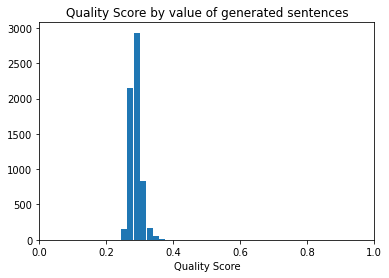

In [66]:
df = pd.DataFrame(np.array(rewards))
df.to_csv("/gdrive/MyDrive/NLP/RESULTS/"+path+"quality_reward.csv")  # Remember to change file name
df[1].astype("float").mean()
df[1].astype("float").hist(rwidth=0.95, grid=False)
plt.title("Quality Score by value of generated sentences")
plt.xlabel("Quality Score")
plt.xlim(left=0, right=1)